In [20]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import random
import nltk
from nltk.corpus import stopwords
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import  get_linear_schedule_with_warmup
from tqdm import tqdm
from torch.optim import AdamW
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [21]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for computation")

Using cuda for computation


In [23]:
nltk.download('stopwords')
nltk.download('punkt')
from datasets import load_dataset
dataset = load_dataset("imdb")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

# Display sample data
print("\nSample reviews:")
print(train_df.head())


Training data shape: (25000, 2)
Testing data shape: (25000, 2)

Sample reviews:
                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


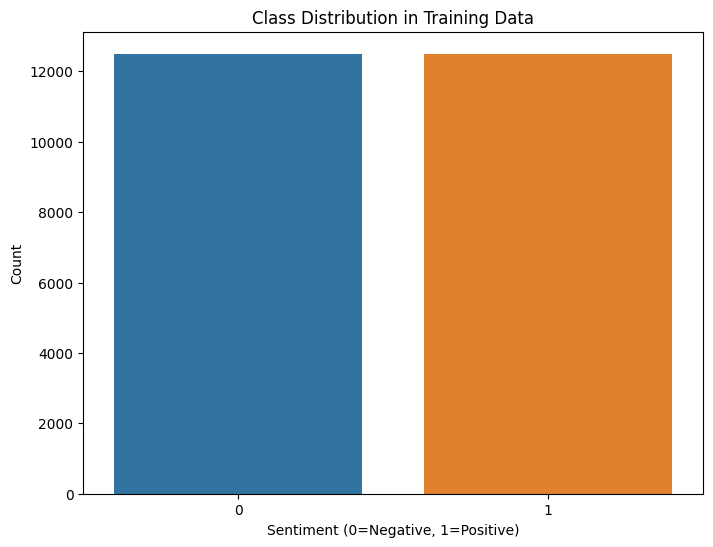

In [25]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution in Training Data')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.show()

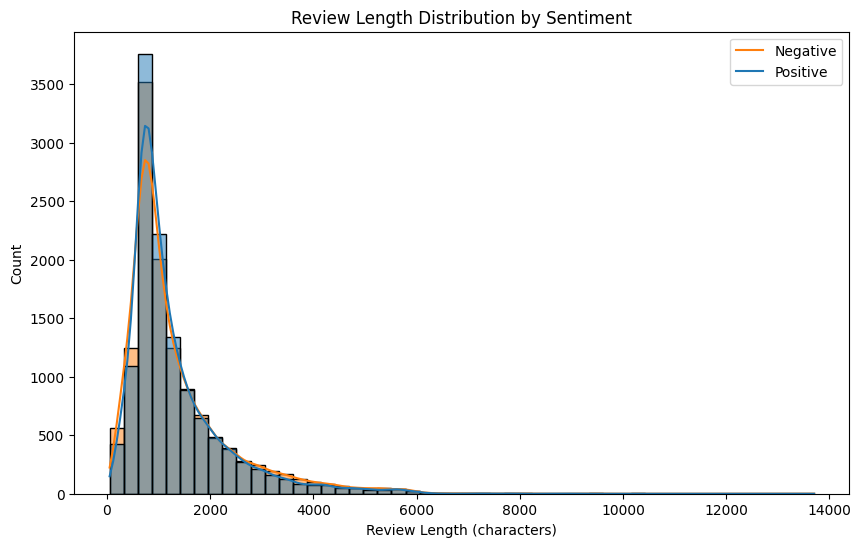

In [26]:
train_df['length'] = train_df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='length', hue='label', bins=50, kde=True)
plt.title('Review Length Distribution by Sentiment')
plt.xlabel('Review Length (characters)')
plt.ylabel('Count')
plt.legend(['Negative', 'Positive'])
plt.show()

In [27]:
print(f"Average review length: {train_df['length'].mean():.2f} characters")
print(f"Median review length: {train_df['length'].median()} characters")
print(f"Max review length: {train_df['length'].max()} characters")

Average review length: 1325.07 characters
Median review length: 979.0 characters
Max review length: 13704 characters


In [28]:
def create_wordcloud(text, title):
    stopwords_set = set(stopwords.words('english'))
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         stopwords=stopwords_set, max_words=200).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

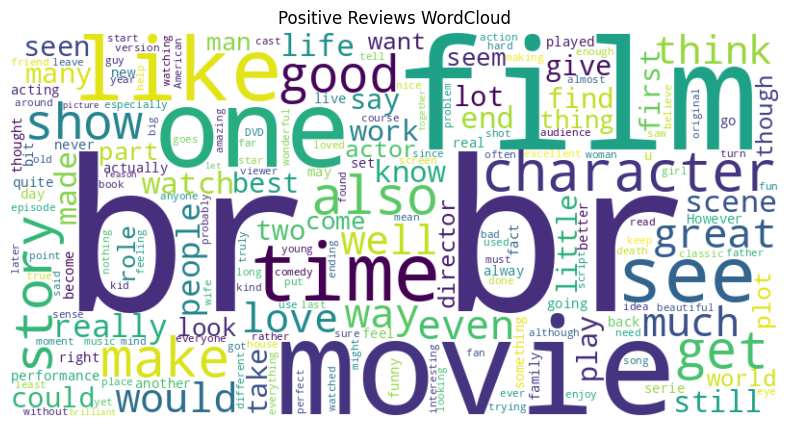

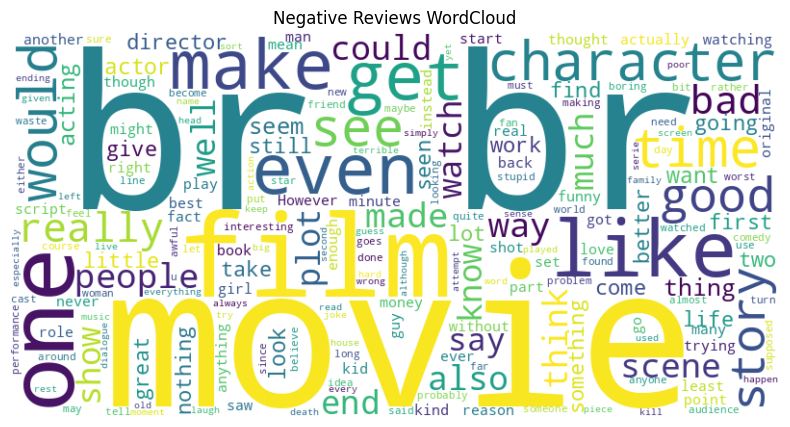

In [29]:
positive_text = ' '.join(train_df[train_df['label'] == 1]['text'].values)
negative_text = ' '.join(train_df[train_df['label'] == 0]['text'].values)

create_wordcloud(positive_text, 'Positive Reviews WordCloud')
create_wordcloud(negative_text, 'Negative Reviews WordCloud')

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [30]:
# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

print("\nSample processed reviews:")
for i in range(2):
    print(f"Original: {train_df['text'].iloc[i][:100]}...")
    print(f"Processed: {train_df['processed_text'].iloc[i][:100]}...")
    print()

# Data Augmentation Techniques
def synonym_replacement(text, n=1):
    """Replace n random words in the text with their synonyms"""
    # Simple implementation for demonstration
    # In a real scenario, you would use a proper synonym dictionary
    common_replacements = {
        'good': ['great', 'excellent', 'fine', 'nice', 'positive'],
        'bad': ['poor', 'terrible', 'awful', 'negative', 'horrible'],
        'movie': ['film', 'picture', 'flick', 'cinema', 'production'],
        'like': ['enjoy', 'appreciate', 'love', 'adore', 'favor'],
        'hate': ['dislike', 'detest', 'loathe', 'despise', 'abhor']
    }
    
    words = text.split()
    if len(words) <= n:
        return text
    
    indices = random.sample(range(len(words)), n)
    for idx in indices:
        word = words[idx].lower()
        if word in common_replacements:
            words[idx] = random.choice(common_replacements[word])
    
    return ' '.join(words)

def random_deletion(text, p=0.1):
    """Randomly delete words from the text with probability p"""
    words = text.split()
    if len(words) == 1:
        return text
    
    new_words = []
    for word in words:
        if random.random() > p:
            new_words.append(word)
    
    if len(new_words) == 0:
        return random.choice(words)
    
    return ' '.join(new_words)

def random_swap(text, n=1):
    """Randomly swap n pairs of words in the text"""
    words = text.split()
    if len(words) <= 1:
        return text
    
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    
    return ' '.join(words)

# Apply augmentation to double the dataset
augmented_texts = []
augmented_labels = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Augmenting data"):
    # Choose a random augmentation technique
    aug_technique = random.choice([synonym_replacement, random_deletion, random_swap])
    augmented_text = aug_technique(row['processed_text'])
    augmented_texts.append(augmented_text)
    augmented_labels.append(row['label'])

# Create augmented DataFrame
aug_df = pd.DataFrame({
    'text': train_df['text'].tolist() + augmented_texts,
    'processed_text': train_df['processed_text'].tolist() + augmented_texts,
    'label': train_df['label'].tolist() + augmented_labels
})

print(f"Original dataset size: {len(train_df)}")
print(f"Augmented dataset size: {len(aug_df)}")


Sample processed reviews:
Original: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...
Processed: i rented i am curiousyellow from my video store because of all the controversy that surrounded it wh...

Original: "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's poli...
Processed: i am curious yellow is a risible and pretentious steaming pile it doesnt matter what ones political ...



Augmenting data: 100%|██████████| 25000/25000 [00:01<00:00, 14357.78it/s]


Original dataset size: 25000
Augmented dataset size: 50000


In [31]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    aug_df['processed_text'].values, 
    aug_df['label'].values, 
    test_size=0.1,
    random_state=seed_val,
    stratify=aug_df['label']
)

# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Move model to GPU
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [32]:
# Tokenize and encode the dataset
def encode_texts(texts, max_length=512):
    return tokenizer(
        texts.tolist() if hasattr(texts, 'tolist') else texts,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

# Encode the training and validation datasets
train_encodings = encode_texts(train_texts)
val_encodings = encode_texts(val_texts)
test_encodings = encode_texts(test_df['processed_text'].values)

In [33]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings.input_ids)


In [35]:
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_df['label'].values)



In [36]:
batch_size = 16

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [37]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Total number of training steps
total_steps = len(train_dataloader) * 3  # 3 epochs

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [38]:
def train(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        
        # Backward pass
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters
        optimizer.step()
        scheduler.step()
    
    return total_loss / len(dataloader)

In [39]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            
            # Get predictions
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    
    return total_loss / len(dataloader), accuracy, all_preds, all_labels


In [40]:
epochs = 3
training_stats = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # Train
    train_loss = train(model, train_dataloader, optimizer, scheduler, device)
    
    # Evaluate on validation set
    val_loss, val_accuracy, val_preds, val_labels = evaluate(model, val_dataloader, device)
    
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Store stats
    training_stats.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    })

# Visualize training stats
stats_df = pd.DataFrame(training_stats)


Epoch 1/3


Evaluating: 100%|██████████| 313/313 [01:21<00:00,  3.86it/s]


Training Loss: 0.2336
Validation Loss: 0.1544
Validation Accuracy: 0.9496

Epoch 2/3


Evaluating: 100%|██████████| 313/313 [01:21<00:00,  3.85it/s]


Training Loss: 0.0940
Validation Loss: 0.1208
Validation Accuracy: 0.9696

Epoch 3/3


Evaluating: 100%|██████████| 313/313 [01:20<00:00,  3.91it/s]

Training Loss: 0.0377
Validation Loss: 0.1174
Validation Accuracy: 0.9756


In [41]:
test_loss, test_accuracy, test_preds, test_labels = evaluate(model, test_dataloader, device)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['Negative', 'Positive']))

Evaluating: 100%|██████████| 1563/1563 [06:41<00:00,  3.90it/s]


Test Loss: 0.3906
Test Accuracy: 0.9252

Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.92      0.92     12500
    Positive       0.92      0.93      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



In [42]:
# Save the model as a pickle file
output_model_file = "distilbert_sentiment_model.pkl"
with open(output_model_file, 'wb') as f:
    pickle.dump({
        'model_state_dict': model.state_dict(),
        'tokenizer': tokenizer,
        'config': model.config
    }, f)

print(f"\nModel saved to {output_model_file}")


Model saved to distilbert_sentiment_model.pkl


In [43]:

from IPython.display import FileLink

FileLink(r'distilbert_sentiment_model.pkl')

/kaggle/working/distilbert_sentiment_model.pkl